# Solution Checker for H2O July 2016 NYC Hackathon

1. [Create solutions file data/newSolution.csv, with the target variable values for the test set.](#Cell1)
1. [Check predictions for public and private leader boards.](#Cell2)
1. [Make a combined plot of weekly RMSE for all the models we tried.](#Cell3)

### Notes:

The full wind turbine data set, including the target variable values for the test set,
is available from Dr. Tao Hong's blog at http://blog.drhongtao.com/. Look for the 
GEFCom2014 data set. If it's not available from the blog it may be downloadable 
via the publications page, http://www.drhongtao.com/publications.

To extract the relevant data, do:
```
unzip GEFCom2014.zip
cd GEFCom2014\ Data/
unzip GEFCom2014-W_V2.zip
cd Wind/Task\ 15/
unzip Task15_W_Zone1_10.zip
cd Task15_W_Zone1_10/
```
The files in this last directory are of the form "Task15_W_ZoneN.csv", where N is a
number between 1 and 10. These files contain the full wind turbine data. 

The first cell below assumes we are sitting in the directory just above the data subdirectory, 
where GEFCom2014.zip was unzipped.

<a id='Cell1'></a>

In [2]:
'''
Create solutions file data/newSolution.csv, with the target variable values for the test set.
'''
import csv
import datetime

path = "data/GEFCom2014 Data/Wind/Task 15/Task15_W_Zone1_10/"
dt1  = datetime.datetime.strptime("2013-08-01 00:00", "%Y-%m-%d %H:%M")
dt2  = datetime.datetime.strptime("2013-12-01 00:00", "%Y-%m-%d %H:%M")

missing_values = []
with open('data/newSolution.csv', 'wb') as ofile:
    ofwriter = csv.writer(ofile)
    ofwriter.writerow(['ID', 'ZONEID', 'TIMESTAMP', 'TARGETVAR', 'U10', 'V10', 'U100', 'V100'])
    for zoneid in range(1,11):
        ifname = path+"Task15_W_Zone"+str(zoneid)+".csv"
        with open(ifname, 'rb') as ifile:
            ifreader = csv.reader(ifile)
            next(ifreader)
            for row in ifreader:
                dt = datetime.datetime.strptime(row[1], "%Y%m%d %H:%M")
                if dt>=dt1 and dt<=dt2:
                    newrow = [zoneid+100*dt.hour+10000*dt.day+(22+dt.month)*1000000]
                    try:
                        targetvar = round(float(row[2]),9)
                    except:
                        targetvar = "NA"
                        missing_values.append([zoneid,row[1]])
                    newrow.extend([row[0],row[1],targetvar])
                    newrow.extend([round(float(row[i]),9) for i in range(3,7)])
                    ofwriter.writerow(newrow)
n_missing = len(missing_values)
print('Number of missing target values: %i\n' %n_missing)
for zoneid in range(1,11):
    missing = [dtval for [ind,dtval] in missing_values if ind==zoneid]
    if len(missing)>0:
        print('For zone ID %i: %s' %(zoneid,missing))

Number of missing target values: 81

For zone ID 1: ['20130815 16:00', '20130920 4:00', '20131022 2:00', '20131101 1:00']
For zone ID 2: ['20130920 4:00', '20131030 21:00', '20131101 1:00', '20131101 16:00', '20131102 23:00']
For zone ID 3: ['20130807 5:00', '20130808 4:00', '20130808 5:00', '20130808 6:00', '20130808 7:00', '20130808 8:00', '20130808 9:00', '20130824 4:00', '20130824 5:00', '20130824 6:00', '20130826 5:00', '20130826 6:00', '20130826 7:00', '20130826 8:00', '20130826 9:00', '20130826 10:00', '20130826 11:00', '20130826 12:00', '20130826 13:00', '20130826 14:00', '20130826 15:00', '20130830 16:00', '20130830 17:00', '20130830 18:00', '20130901 16:00', '20130901 17:00', '20130901 18:00', '20130901 19:00', '20130901 20:00', '20130901 21:00', '20130901 22:00', '20130901 23:00', '20130902 0:00', '20130902 1:00', '20130902 2:00', '20130902 3:00', '20130902 4:00', '20130902 5:00', '20130902 6:00', '20130902 7:00', '20130902 8:00', '20130902 9:00', '20130902 10:00', '20130902

<a id='Cell2'></a>

In [1]:
'''
Check predictions for public and private leader boards.
'''
import csv
import datetime
import numpy as np

#prediction_file = 'data/turbineOutputs10.csv'
#prediction_file = 'data/turbineOutputsTest03.csv'
#prediction_file = 'data/turbineOutputsTest04.csv'
#prediction_file = 'data/rfr_2017_03_15_17_03_01.out.csv'
#prediction_file = 'data/rfr_2017_04_04_15_51_02.out.csv' # random forest, rm=3, dups removed
#prediction_file = 'data/rfr_2017_04_04_22_37_40.out.csv' #* rfr, rm=3, dups removed
#prediction_file = 'data/rfr_2017_04_04_22_49_03.out.csv' #* rfr, rm=1
#prediction_file = 'data/rfr_2017_04_18_01_31_04.out.csv' #* rfr, rm=1, dups removed
#prediction_file = 'data/rfr_2017_04_18_19_20_54.out.csv' # Init rfr, rm=1, no dups, ntrs=2000, mxdpth=40, mnsleaf=3
#prediction_file = 'data/rfr_2017_04_18_19_35_11.out.csv' # Init rfr, rm=1, no dups, ntrs=1000, mxdpth=30, mnsleaf=5
#prediction_file = 'data/rfr_2017_04_04_23_41_57.out.csv' # Initial rfr notebook
#prediction_file = 'data/rfr_2017_04_05_16_34_41.out.csv' # Initial rfr notebook, refactored
#prediction_file = 'data/rfr_2017_04_05_23_21_53.out.csv' # Initial rfr notebook, refactored
#prediction_file = 'data/rfr_2017_04_06_15_45_18.out.csv' # Initial rfr, refactored, max_features=15
#prediction_file = 'data/rfr_2017_04_07_00_44_36.out.csv' # Init. rfr, optimizd, ntrees=2000, mxdepth=40, mnsleaf=3
#prediction_file = 'data/rfr_2017_04_07_23_16_55.out.csv' # Initial rfr, without zoneid information
#prediction_file = 'data/rfr_2017_04_08_21_31_35.out.csv' # Initial rfr, rm=1
#prediction_file = 'data/rfr_2017_04_22_10_58_06.out.csv' #* Init rfr, rm=3, opt., ntrees=3000, mxdpth=50, mnsleaf=3

#prediction_file = 'data/xgb_out_2017_03_02_16_26_42.csv'
#prediction_file = 'data/xgb_out_2017_03_04_16_12_45.csv'
#prediction_file = 'data/xgb_out_2017_03_05_10_24_03.csv'
#prediction_file = 'data/xgb_2017_03_05_17_57_26.out.csv'
#prediction_file = 'data/xgbc_2017_03_06_13_07_26.out.csv'
#prediction_file = 'data/xgbc_2017_03_08_17_42_23.out.csv'
#prediction_file = 'data/xgbc_2017_03_08_17_59_12.out.csv'
#prediction_file = 'data/xgbr_2017_03_12_10_32_47.out.csv' # rm=2
#prediction_file = 'data/xgb_2017_03_10_06_48_40.out.csv' # With rolling average over 3 measurements
#prediction_file = 'data/xgbr_2017_03_10_22_16_39.out.csv' # With rolling average over 3 measurements
#prediction_file = 'data/xgbrc_2017_03_11_02_04_14.out.csv' # rm=3 plus classifier correction
#prediction_file = 'data/xgbr_2017_03_11_10_49_07.out.csv' # rm=4
prediction_file = 'data/xgbr_2017_10_23_04_03_11.out.csv' # rm=3, dups removed, single obs retained
#prediction_file = 'data/xgbr_2017_03_28_09_06_00.out.csv' #* rm=3, dups removed
#prediction_file = 'data/xgbr_2017_03_29_05_22_41.out.csv' # rm=3, dups removed, (U,V,time) replaced by (H)
#prediction_file = 'data/xgbrc_2017_04_04_02_23_28.out.csv' # rm=3, dups removed, classifier correction
#prediction_file = 'data/xgbrc_2017_04_04_11_20_24.out.csv' # rm=3, dups removed, class corr T=0.001
#prediction_file = 'data/xgbrc_2017_04_04_11_23_18.out.csv' # rm=3, dups removed, class corr T=0.0001
#prediction_file = 'data/xgbrc_2017_04_04_11_26_43.out.csv' # rm=3, dups removed, class corr T=0.0
#prediction_file = 'data/xgbrc_2017_04_04_11_37_56.out.csv' # rm=3, dups removed, class corr T=0.0, except. Turb 4

#prediction_file = 'data/gamr_2017_03_28_16_15_35.out.csv' # gamlss predictions with rm=3
#prediction_file = 'data/gamr_2017_03_28_17_38_19.out.csv' # gamlss predictions with rm=3, predictor p-value>5%
#prediction_file = 'data/gamr_2017_04_20_16_39_11.out.csv' #* gamlss with rm=3, fit mu & nu, y_pred weighted avg.
solution_file   = 'data/Solution.csv'
dt1             = datetime.datetime.strptime("2013-08-01 00:00", "%Y-%m-%d %H:%M")
dt2             = datetime.datetime.strptime("2013-09-30 23:00", "%Y-%m-%d %H:%M")
dt3             = datetime.datetime.strptime("2013-12-01 00:00", "%Y-%m-%d %H:%M")

prediction_dict = {}
with open(prediction_file, 'rb') as pfile:
    pfreader = csv.reader(pfile)
    next(pfreader)
    for row in pfreader:
        rowid = int(row[0])
        try:
            targetvar = float(row[1])
            prediction_dict[rowid] = targetvar
        except:
            pass
            
public_solution_dict   = {}
private_solution_dict  = {}
npass_public           = 0
npass_private          = 0
with open(solution_file, 'rb') as sfile:
    sfreader = csv.reader(sfile)
    next(sfreader)
    for row in sfreader:
        dt = datetime.datetime.strptime(row[2], "%Y%m%d %H:%M")
        if dt>=dt1 and dt<=dt2:
            rowid = int(row[0])
            try:
                targetvar = float(row[3])
                public_solution_dict[rowid] = targetvar
            except:
                npass_public  += 1
        elif dt>dt2 and dt<=dt3:
            rowid = int(row[0])
            try:
                targetvar = float(row[3])
                private_solution_dict[rowid] = targetvar
            except:
                npass_private += 1
print('Bad records in public solution: %i, in private solution: %i\n' %(npass_public,npass_private))
nitems = 0
sumsqd = 0.0
for key,value in public_solution_dict.items():
    predval = prediction_dict[key]
    sumsqd += (predval-value)**2
    nitems += 1
rmse = np.sqrt(sumsqd/nitems)
print('Public Leader Board:  RMSE = %s, Predictions included: %i' %(rmse,nitems))

nitems = 0
sumsqd = 0.0
for key,value in private_solution_dict.items():
    predval = prediction_dict[key]
    sumsqd += (predval-value)**2
    nitems += 1
rmse = np.sqrt(sumsqd/nitems)
print('Private Leader Board: RMSE = %s, Predictions included: %i' %(rmse,nitems))

Bad records in public solution: 74, in private solution: 7

Public Leader Board:  RMSE = 0.165330224696, Predictions included: 14566
Private Leader Board: RMSE = 0.167065325737, Predictions included: 14643


Public leader board:  RMSE12 = 0.167222837934, predictions included = 14566
Private leader board: RMSE12 = 0.174104698955, predictions included = 14643
Public leader board:  RMSE13 = 0.16760745779, predictions included = 14566
Private leader board: RMSE13 = 0.168778176513, predictions included = 14643
Public leader board:  RMSE14 = 0.167303322989, predictions included = 14566
Private leader board: RMSE14 = 0.176077228184, predictions included = 14643
Public leader board:  RMSE15 = 0.157353008217, predictions included = 14566
Private leader board: RMSE15 = 0.164688854367, predictions included = 14643
Number of time points:                 2929
Number of delta-times equal to 1 hour: 2928


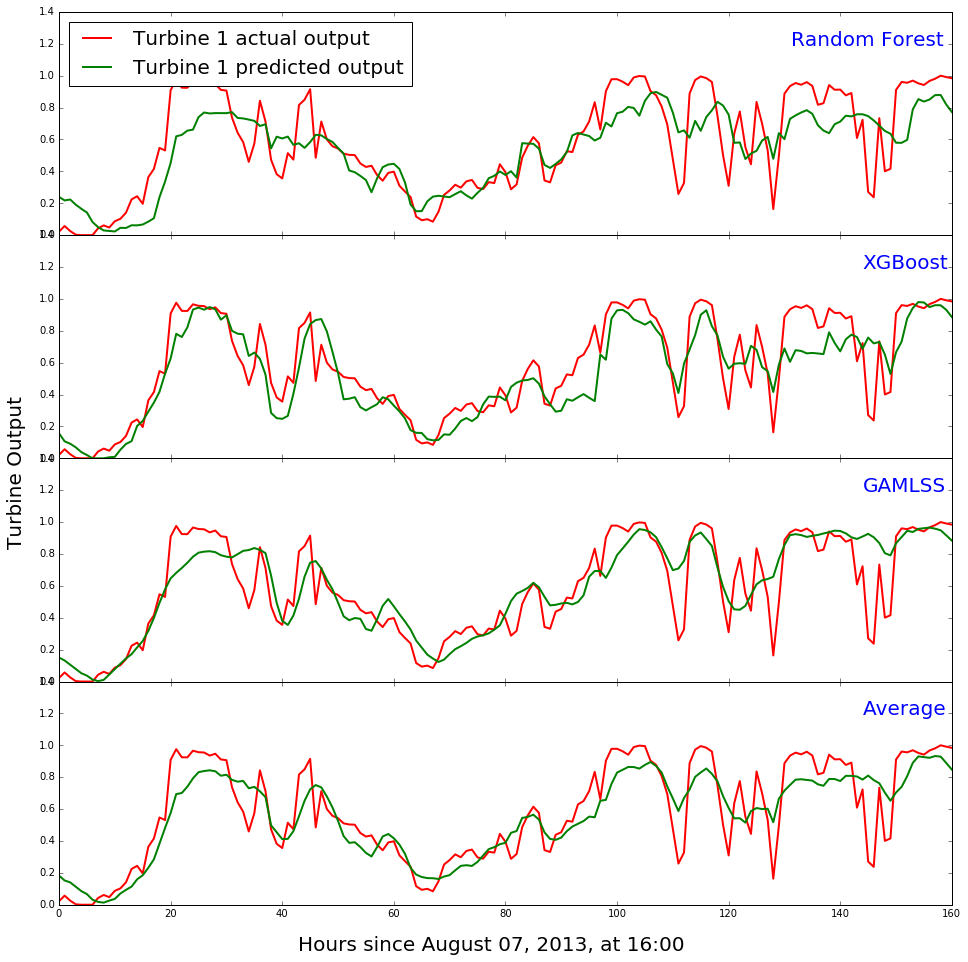

In [7]:
'''
Plot predicted and actual turbine power as a function of time (from test set).
'''
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Set plot parameters
turbine = 1
npts1   = 160
npts2   = 320

# Read in the data, join by observation ID.
df1 = pd.read_csv('data/solution.csv', header=0, parse_dates=[2])
df2 = pd.read_csv('data/rfr_2017_04_22_10_58_06.out.csv', header=0)
df3 = pd.read_csv('data/xgbr_2017_03_28_09_06_00.out.csv', header=0)
df4 = pd.read_csv('data/gamr_2017_04_20_16_39_11.out.csv', header=0)

df0 = pd.merge(df1, df2, how='inner', on='ID', suffixes=('_1', '_2'))
df0 = pd.merge(df0, df3, how='inner', on='ID')
df0.rename(columns = {'TARGETVAR':'TARGETVAR_3'}, inplace = True)
df0 = pd.merge(df0, df4, how='inner', on='ID')
df0.rename(columns = {'TARGETVAR':'TARGETVAR_4'}, inplace = True)
df0['AVGPRED'] = (df0.TARGETVAR_2 + df0.TARGETVAR_3 + df0.TARGETVAR_4)/3.

# Compute performance measures
dt1     = datetime.datetime.strptime("2013-08-01 00:00", "%Y-%m-%d %H:%M")
dt2     = datetime.datetime.strptime("2013-09-30 23:00", "%Y-%m-%d %H:%M")
dt3     = datetime.datetime.strptime("2013-12-01 00:00", "%Y-%m-%d %H:%M")
df0c    = df0.dropna(axis=0, how='any')
df0c1   = df0c[(df0c.TIMESTAMP>=dt1) & (df0c.TIMESTAMP<=dt2)]
df0c2   = df0c[(df0c.TIMESTAMP>dt2) & (df0c.TIMESTAMP<=dt3)]
rmse12a = np.sqrt(((df0c1.TARGETVAR_1-df0c1.TARGETVAR_2)**2).mean())
rmse12b = np.sqrt(((df0c2.TARGETVAR_1-df0c2.TARGETVAR_2)**2).mean())
rmse13a = np.sqrt(((df0c1.TARGETVAR_1-df0c1.TARGETVAR_3)**2).mean())
rmse13b = np.sqrt(((df0c2.TARGETVAR_1-df0c2.TARGETVAR_3)**2).mean())
rmse14a = np.sqrt(((df0c1.TARGETVAR_1-df0c1.TARGETVAR_4)**2).mean())
rmse14b = np.sqrt(((df0c2.TARGETVAR_1-df0c2.TARGETVAR_4)**2).mean())
rmse15a = np.sqrt(((df0c1.TARGETVAR_1-df0c1.AVGPRED)**2).mean())
rmse15b = np.sqrt(((df0c2.TARGETVAR_1-df0c2.AVGPRED)**2).mean())
print('Public leader board:  RMSE12 = {0}, predictions included = {1}'.format(rmse12a, len(df0c1)))
print('Private leader board: RMSE12 = {0}, predictions included = {1}'.format(rmse12b, len(df0c2)))
print('Public leader board:  RMSE13 = {0}, predictions included = {1}'.format(rmse13a, len(df0c1)))
print('Private leader board: RMSE13 = {0}, predictions included = {1}'.format(rmse13b, len(df0c2)))
print('Public leader board:  RMSE14 = {0}, predictions included = {1}'.format(rmse14a, len(df0c1)))
print('Private leader board: RMSE14 = {0}, predictions included = {1}'.format(rmse14b, len(df0c2)))
print('Public leader board:  RMSE15 = {0}, predictions included = {1}'.format(rmse15a, len(df0c1)))
print('Private leader board: RMSE15 = {0}, predictions included = {1}'.format(rmse15b, len(df0c2)))

# Verify that the data are in chronological order, with delta-times of 1 hour.
df0t             = df0[df0.ZONEID==turbine]
dtimes           = df0t["TIMESTAMP"].subtract(df0t["TIMESTAMP"].shift(+1))
Ntimepoints      = len(df0t)
Ndeltatimes1h    = dtimes[dtimes==np.timedelta64(1, 'h')].count()
assert (Ntimepoints == Ndeltatimes1h+1), 'Delta times not all equal to 1 h!'
print('Number of time points:                 {0}'.format(Ntimepoints))
print('Number of delta-times equal to 1 hour: {0}'.format(Ndeltatimes1h))

# Prepare data points to be plotted
targets = df0t['TARGETVAR_1']
pred1   = df0t['TARGETVAR_2']
pred2   = df0t['TARGETVAR_3']
pred3   = df0t['TARGETVAR_4']
pred4   = df0t['AVGPRED']

npts_pt    = len(targets)
assert npts1<npts2 and npts2<npts_pt, 'Invalid data point range!'
start_time = df0t.TIMESTAMP[npts1].strftime('%B %d, %Y, at %H:%M')
xval       = range(0, npts2-npts1+1)
yval       = targets[npts1:npts2+1]
zval1      = pred1[npts1:npts2+1]
zval2      = pred2[npts1:npts2+1]
zval3      = pred3[npts1:npts2+1]
zval4      = pred4[npts1:npts2+1]

# Create plot
fig, ax    = plt.subplots( nrows=4, ncols=1, sharex=True, figsize=(16,16))
plt.subplots_adjust( wspace=0.25, hspace=0.0)
ax[0].plot(xval, yval, color="red", linewidth=2.0, label="Turbine "+str(turbine)+" actual output")
ax[0].plot(xval, zval1, color="green", linewidth=2.0, label="Turbine "+str(turbine)+" predicted output")
ax[0].set_xlim([0, npts2-npts1])
ax[0].set_ylim([0., 1.4])
ax[0].legend(prop={'size': 20},loc="upper left")
ax[0].text(0.82, 0.85, 'Random Forest', transform=ax[0].transAxes, color='blue', fontsize=20)
ax[1].plot(xval, yval, color="red", linewidth=2.0)
ax[1].plot(xval, zval2, color="green", linewidth=2.0)
ax[1].set_xlim([0, npts2-npts1])
ax[1].set_ylim([0., 1.4])
ax[1].text(0.90, 0.85, 'XGBoost', transform=ax[1].transAxes, color='blue', fontsize=20)
ax[2].plot(xval, yval, color="red", linewidth=2.0)
ax[2].plot(xval, zval3, color="green", linewidth=2.0)
ax[2].set_xlim([0, npts2-npts1])
ax[2].set_ylim([0., 1.4])
ax[2].text(0.90, 0.85, 'GAMLSS', transform=ax[2].transAxes, color='blue', fontsize=20)
ax[3].plot(xval, yval, color="red", linewidth=2.0)
ax[3].plot(xval, zval4, color="green", linewidth=2.0)
ax[3].set_xlim([0, npts2-npts1])
ax[3].set_ylim([0., 1.4])
ax[3].text(0.90, 0.85, 'Average', transform=ax[3].transAxes, color='blue', fontsize=20)

fig.text(0.5, 0.085, 'Hours since ' + start_time, ha='center', fontsize=20)
fig.text(0.08, 0.5, 'Turbine Output', va='center', rotation='vertical', fontsize=20)

plt.show()
fig.savefig('pred_actual_vs_time.png', dpi=200, bbox_inches='tight')

<a id='Cell3'></a>

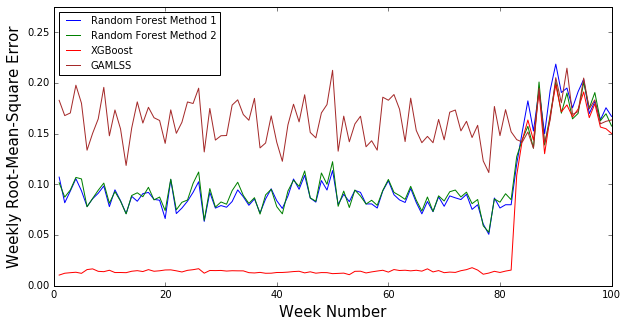

In [2]:
'''
Make a combined plot of weekly RMSE for all the models we tried.
'''

import csv
import matplotlib.pyplot as plt
%matplotlib inline

with open('data/rfr35_weekly_rmse.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    rfr35  = next(reader)
with open('data/rfr16_weekly_rmse.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    rfr16  = next(reader)
with open('data/xgbr_weekly_rmse.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    xgbr   = next(reader)
with open('data/gamr_weekly_rmse.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    gamr   = next(reader)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
axis.plot(range(1,101), rfr35, color="blue",  label="Random Forest Method 1" )
axis.plot(range(1,101), rfr16, color="green", label="Random Forest Method 2" )
axis.plot(range(1,101), xgbr,  color="red",   label="XGBoost" )
axis.plot(range(1,101), gamr,  color="brown", label="GAMLSS" )
axis.set_xlabel("Week Number", fontsize=15)
axis.set_ylabel("Weekly Root-Mean-Square Error", fontsize=15)
axis.set_ylim(0.0, 0.275)
axis.legend(prop={'size': 10},loc="upper left")
plt.show()
fig.savefig('weekly_rmse_all.png', dpi=200, bbox_inches='tight')